# 2019 2nd ML month with KaKR
### 평가문항
1. 케글 데이터분석 전과정이 성공적으로 진행되었는가?
- 작성한 노트북을 캐글에 제출했다.
2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
- 제출한 주피터노트북 파일이 캐글 커널 환경에서도 에러 없이 동작하며, 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.


### 데이터 불러오기

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from os.path import join

In [164]:
data_dir = '~/development/Aiffel/Aiffel_online5/Exploration2/data'
train_data_path = join(data_dir, 'train.csv') # train data path
sub_data_path = join(data_dir, 'test.csv') # test data path

data = pd.read_csv(train_data_path) # train data
sub = pd.read_csv(sub_data_path) # test data

In [165]:
data_x = data.drop(columns='price') # label 제거

### 데이터 전처리

#### 결측치 확인

In [166]:
df = pd.concat((data_x, sub), axis = 0) # train, test data concat

In [167]:
df.isna().sum().sum() # 결측치 확인. 결측치 없음

0

#### date 처리

In [168]:
sub['date'] = sub['date'].apply(lambda x : str(x[:6])).astype(int)
data['date'] = data['date'].apply(lambda x: str(x[:6])).astype(int)

In [169]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 반응변수 X 확인

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<Axes: >

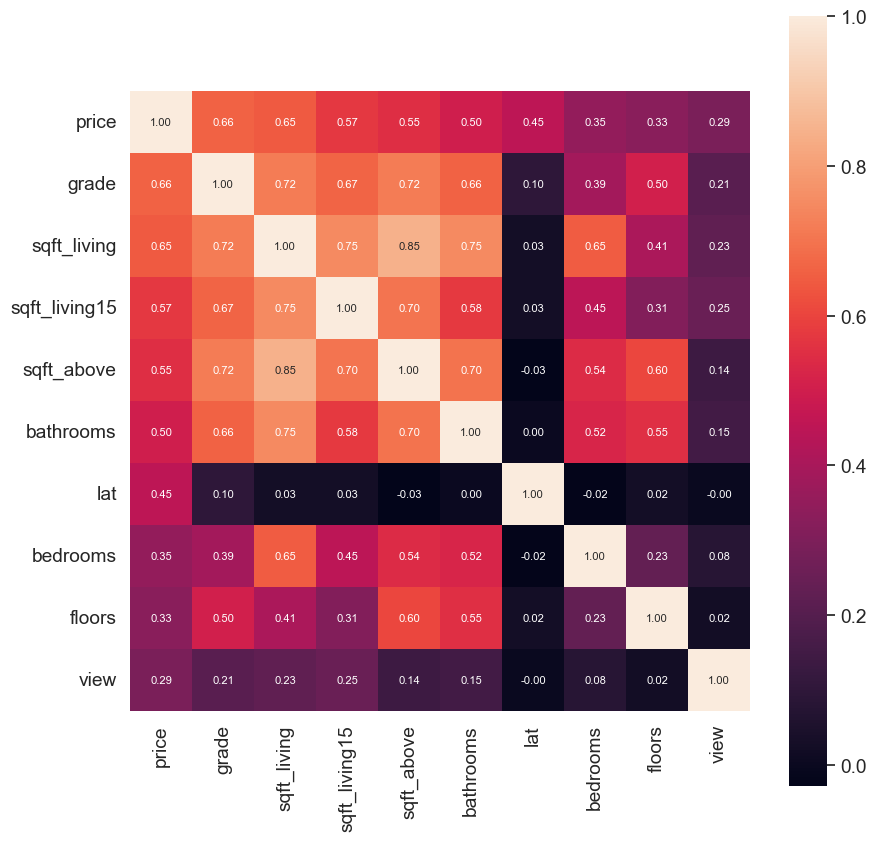

In [170]:
import scipy as sp

cor_abs = abs(data.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns = 'price').index

cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True,\
             annot_kws={'size':8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

<Axes: xlabel='grade', ylabel='price'>

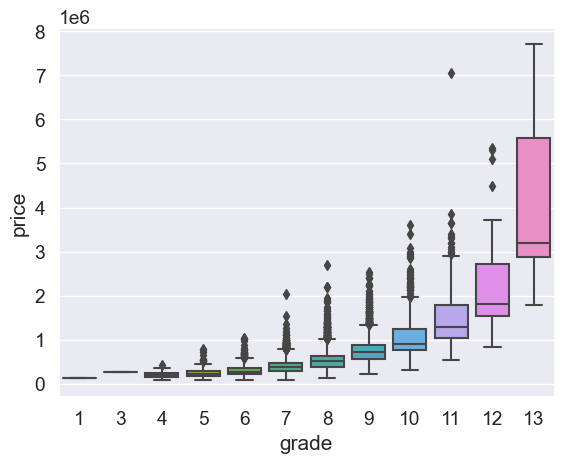

In [171]:
temp = pd.concat([data['price'], data['grade']], axis=1)
sns.boxplot(x='grade', y='price', data=temp)
# 3이 조금 높고, 7,8,9,10 에서 이상치가 많이 보인다. 11에서는 차이가 큰 이상치도 찾을 수 있다.

<Axes: xlabel='sqft_living', ylabel='price'>

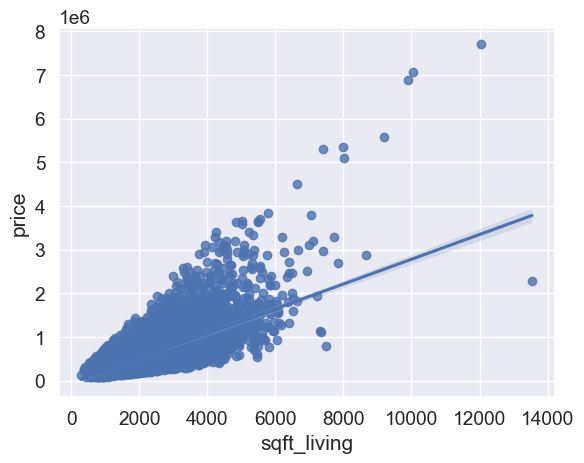

In [172]:
temp = pd.concat([data['price'], data['sqft_living']], axis=1)
sns.regplot(x='sqft_living', y='price', data=temp)
# 전반적으로 선형성을 보이지만 10000~12000 정도에 이상치처럼 보이는 값들이 있다.

<Axes: xlabel='sqft_living15', ylabel='price'>

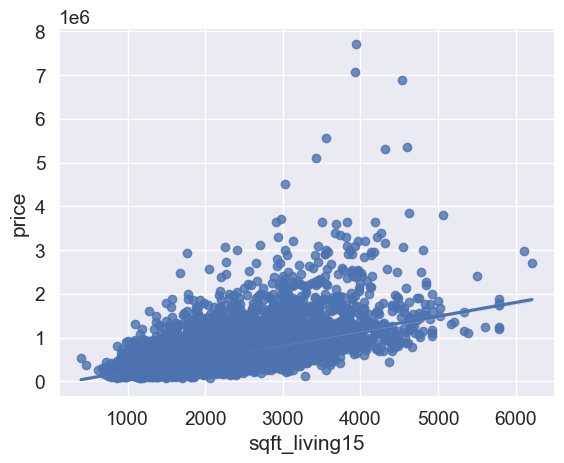

In [173]:
temp = pd.concat([data['price'], data['sqft_living15']], axis=1)
sns.regplot(x='sqft_living15', y='price', data=temp)

<Axes: xlabel='sqft_above', ylabel='price'>

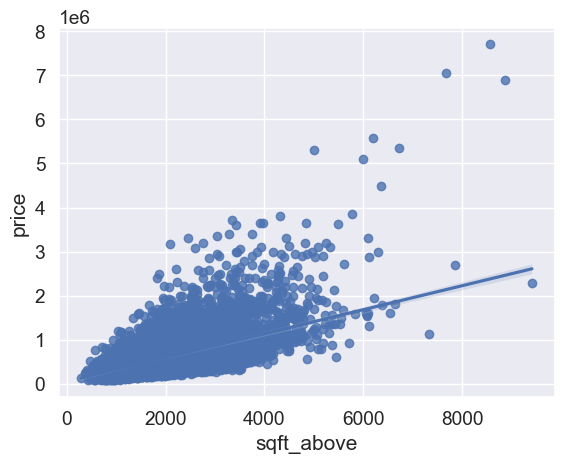

In [174]:
temp = pd.concat([data['price'], data['sqft_above']], axis=1)
sns.regplot(x='sqft_above', y='price', data=temp)

<Axes: xlabel='bathrooms', ylabel='price'>

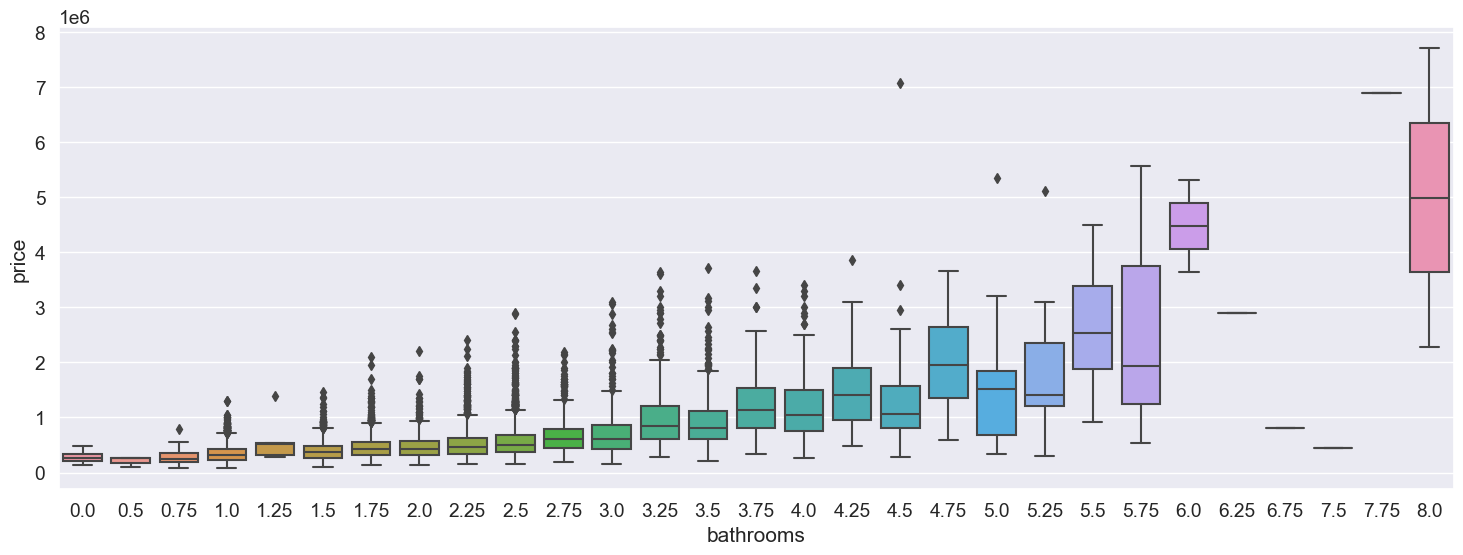

In [175]:
temp = pd.concat([data['price'], data['bathrooms']], axis=1)
f,ax = plt.subplots(figsize=(18,6))
sns.boxplot(x='bathrooms', y='price', data=temp)

<Axes: xlabel='bedrooms', ylabel='price'>

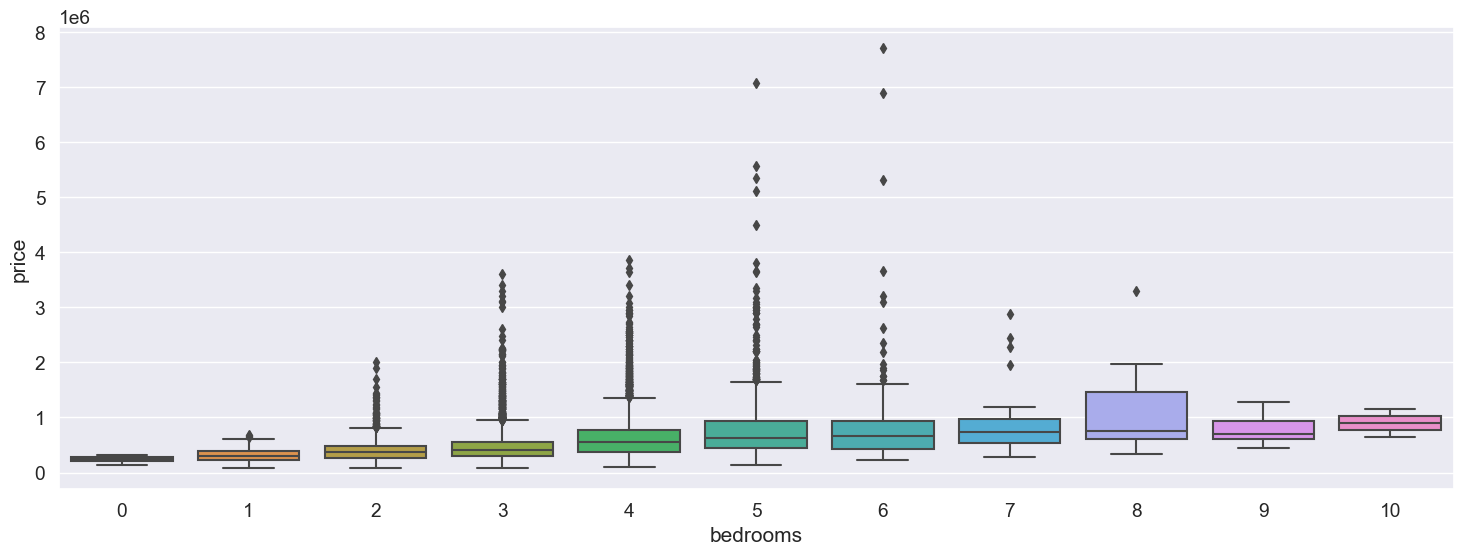

In [176]:
temp = pd.concat([data['price'], data['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18,6))
sns.boxplot(x='bedrooms', y='price', data=temp)

이상치처럼 보이는 값을 확인한 결과 평수가 크거나 등의 이유가 있어 일단 포함시키도록 함

In [180]:
x = data.drop(columns='price')
sub_id = sub['id']
y = data['price']
print(x.shape, sub.shape, y.shape)

(15035, 20) (6468, 20) (15035,)


#### 정규화

In [181]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    x[c] = np.log1p(x[c].values)
    sub[c] = np.log1p(sub[c].values)

In [182]:
x = x.drop(columns='id')
sub = sub.drop(columns='id')

In [183]:
y.describe() # min, max의 차이가 크다.

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Density'>

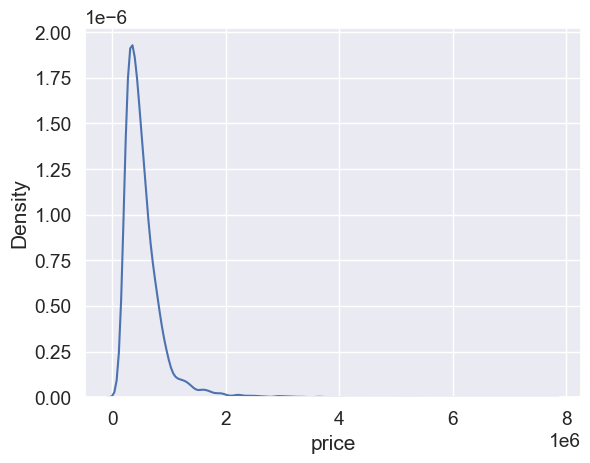

In [184]:
sns.kdeplot(y) # 왼쪽으로 치우친 그래프

<Axes: xlabel='price', ylabel='Density'>

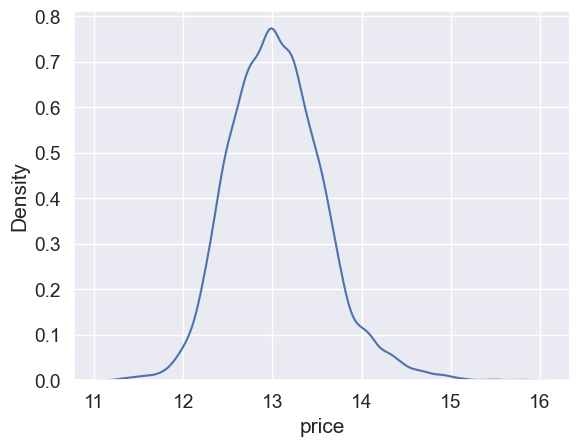

In [185]:
y = np.log1p(y)
sns.kdeplot(y) # log를 취해서 정규성을 가지게 해줌

### 모델링

In [186]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [187]:
random_state = 2023

In [188]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [189]:
def my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5, cv=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',\
                              cv=cv, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(x, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    result = pd.DataFrame(params)
    result['score'] = score
    
    result['RMSLE'] = np.sqrt(-1 * result['score'])
    result = result.sort_values('RMSLE')

    return result

In [199]:
param_grid1 = {
    'n_estimators': [100, 500],
    'max_depth': [1,10,12],
    'learning_rate':[0.05, 0.1],
}

param_grid2 = {
    'n_estimators': [10, 100],
    'max_depth': [6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20],
}

param_grid3 = {
    'learning_rate':[0.01, 0.05],
    'n_estimators': [500, 1000],
    'max_depth':[7, 10, 15],
}
    
param_grid4 = {
    'learning_rate':[0.01, 0.05],
    'max_depth':[10, 15],
    'n_estimators':[100, 500]
}

model1 = GradientBoostingRegressor(random_state=random_state)
model2 = RandomForestRegressor(random_state=random_state)
model3 = lgb.LGBMRegressor(random_state=random_state)
model4 = xgb.XGBRegressor(random_state=random_state)

my_GridSearch(model4, x, y, param_grid4, verbose=2, n_jobs=-1, cv=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   1.0s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   1.0s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=100; total time=   0.8s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=100; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=100; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=100; total time=   1.0s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=100; total time=   1.0s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=500; total time=   9.0s
[CV] END .learning_rate=0.01, max_depth=10, n_est

,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.05,10,500,-0.026461,0.162668
7,0.05,15,500,-0.027475,0.165756
4,0.05,10,100,-0.035361,0.188046
6,0.05,15,100,-0.035897,0.189466
1,0.01,10,500,-0.036480,0.190999
3,0.01,15,500,-0.037182,0.192826
0,0.01,10,100,-21.218391,4.606342
2,0.01,15,100,-21.218391,4.606342


In [200]:
gboost = GradientBoostingRegressor(random_state=random_state, learning_rate=0.05, max_depth=10, n_estimators= 500)
xgboost = xgb.XGBRegressor(random_state=random_state, learning_rate=0.05, max_depth=10, n_estimators=500)
lightgbm = lgb.LGBMRegressor(random_state=random_state, learning_rate=0.05, max_depth=7, n_estimators=1000)
rdforest = RandomForestRegressor(random_state=random_state, max_depth=12, min_samples_leaf=8, min_samples_split=16, n_estimators=100)

#models= [{'model':gboost, 'name':'GradientBoosting' },{'model':xgboost,'name':'XGBoost'}, \
#         {'model':lightgbm,'name':'LightGBM'}, {'model':rdforest,'name':'RandomForestRegressor'}]
models= [{'model':xgboost,'name':'XGBoost'},{'model':lightgbm,'name':'LightGBM'}]

In [192]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score: {CV_score:.4f}")

In [193]:
#get_cv_score(models)

In [201]:
def AveragingBlending(models, x, y, sub):
    for m in models:
        m['model'].fit(x.values, y)

    pred = np.column_stack([
        np.expm1(m['model'].predict(sub.values)) for m in models
    ])
    return np.mean(pred, axis=1)

In [202]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 505206.8302067 ,  466612.21230602, 1337887.79584332, ...,
        476540.69908056,  328361.3828658 ,  450760.32583683])

In [196]:
#lightgbm.fit(x.values, y)
#y_pred = lightgbm.predict(sub.values)
#y_pred = np.expm1(y_pred)

In [50]:
result = pd.DataFrame({
    'id': sub_id,
    'price':y_pred
})

result.head()

,id,price
0,15035,4.931166e+05
1,15036,4.721286e+05
2,15037,1.333782e+06
3,15038,2.998850e+05
4,15039,3.290888e+05


In [204]:
my_submission_path = join(data_dir, 'submssion.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

~/development/Aiffel/Aiffel_online5/Exploration2/data/submssion.csv
